# Import & EDA - HR Analytics: Job Change of Data Scientists

## Setup

In [1]:
import os
from pprint import pprint 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import missingno as msno
import statsmodels.formula.api as smf
import phik

plt.rc("axes.spines", top=False, right=False)
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from fancyimpute import KNN
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, Normalizer, QuantileTransformer, MinMaxScaler, KBinsDiscretizer, PolynomialFeatures, FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import category_encoders as ce
from imblearn.over_sampling import SMOTE
from six import StringIO
from IPython.display import Image
from pydot import graph_from_dot_data
from sklearn import tree
from dtreeviz.trees import *
import graphviz
from sklearn.metrics import recall_score,precision_score,accuracy_score, f1_score, ConfusionMatrixDisplay,roc_auc_score,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [3]:
HR_ANALYSIS_PATH = os.path.join("../input/aug_train.csv")

## Import Data

In [4]:
# Import data
hr_data = pd.read_csv(HR_ANALYSIS_PATH)
hr_data.head(3)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0


In [5]:
unique_ids = hr_data["enrollee_id"].unique()
unique_ids

array([ 8949, 29725, 11561, ..., 24576,  5756, 23834], dtype=int64)

## Train Test Split

In [6]:
train, test = train_test_split(unique_ids, random_state=42)

In [7]:
df_train = hr_data.loc[hr_data["enrollee_id"].isin(train)]
print(df_train.shape)

(14368, 14)


In [8]:
df_test = hr_data.loc[hr_data["enrollee_id"].isin(test)]
print(df_test.shape)

(4790, 14)


In [9]:
df_train.head(3)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [10]:
df_test.head(3)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
6,28806,city_160,0.920,Male,Has relevent experience,no_enrollment,High School,NaN,5,50-99,Funded Startup,1,24,0.0


## Exploratory Data Analysis (EDA)

### Pandas Profiling Report (df_train)

In [11]:
#profile = ProfileReport(df_train, title="Pandas Profiling Report - HR-Analysis")
#profile.to_file(output_file=os.path.join("output", "hr-analysis-profile.html"))

**Features:**

enrollee_id : Unique ID for candidate

city: City code

city_ development _index : Developement index of the city (scaled)

gender: Gender of candidate

relevent_experience: Relevant experience of candidate


enrolled_university: Type of University course enrolled if any

education_level: Education level of candidate

major_discipline :Education major discipline of candidate

experience: Candidate total experience in years

company_size: No of employees in current employer's company

company_type : Type of current employer

lastnewjob: Difference in years between previous job and current job

training_hours: training hours completed

target: 0 – Not looking for job change, 1 – Looking for a job change


**Warnings:**

city has a high cardinality: 122 distinct values

gender has 3410 (23.7%) missing values

enrolled_university has 290 (2.0%) missing values

education_level has 342 (2.4%) missing values

major_discipline has 2105 (14.7%) missing values

company_size has 4475 (31.1%) missing values

company_type has 4628 (32.2%) missing values

last_new_job has 312 (2.2%) missing values

df_index has unique values

enrollee_id has unique values

### Basic Info

In [12]:
df_test.describe()

,enrollee_id,city_development_index,training_hours,target
count,4790.000000,4790.000000,4790.000000,4790.000000
mean,16920.934656,0.828924,66.241754,0.251775
std,9596.855572,0.124013,60.984952,0.434078
min,5.000000,0.448000,1.000000,0.000000
25%,8573.750000,0.739250,23.000000,0.000000
50%,17060.500000,0.910000,48.000000,0.000000
75%,25190.500000,0.920000,90.000000,1.000000
max,33368.000000,0.949000,336.000000,1.000000


In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14368 entries, 1 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             14368 non-null  int64  
 1   city                    14368 non-null  object 
 2   city_development_index  14368 non-null  float64
 3   gender                  10958 non-null  object 
 4   relevent_experience     14368 non-null  object 
 5   enrolled_university     14078 non-null  object 
 6   education_level         14026 non-null  object 
 7   major_discipline        12263 non-null  object 
 8   experience              14322 non-null  object 
 9   company_size            9893 non-null   object 
 10  company_type            9740 non-null   object 
 11  last_new_job            14056 non-null  object 
 12  training_hours          14368 non-null  int64  
 13  target                  14368 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

### Missing Values

In [14]:
df_train.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    3410
relevent_experience          0
enrolled_university        290
education_level            342
major_discipline          2105
experience                  46
company_size              4475
company_type              4628
last_new_job               312
training_hours               0
target                       0
dtype: int64

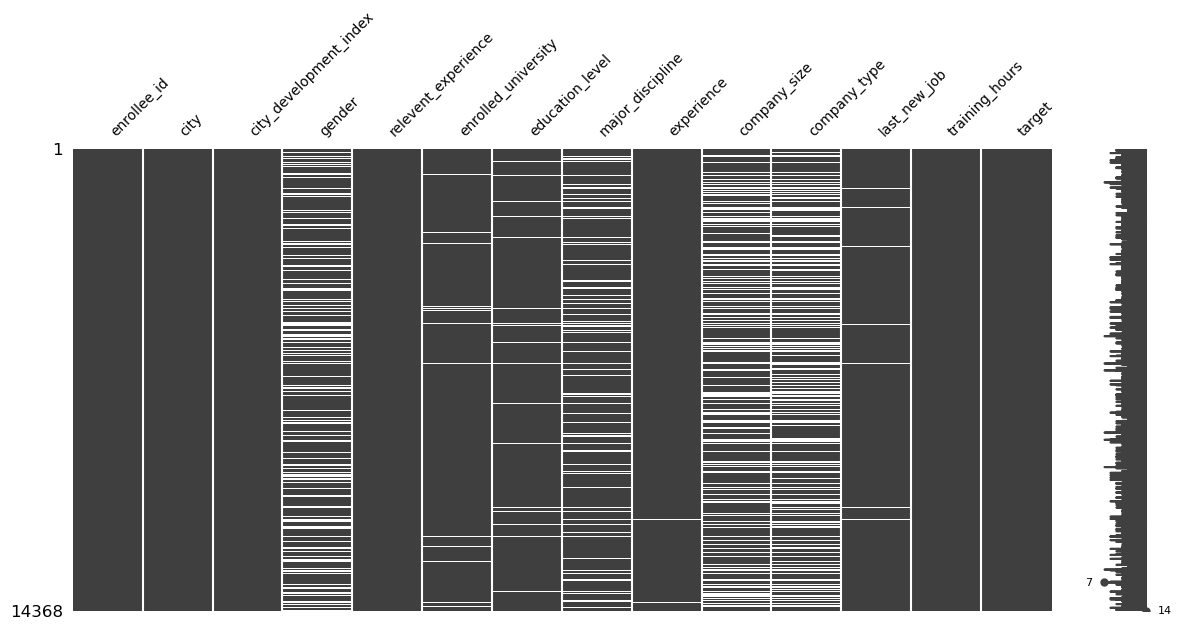

In [15]:
#%matplotlib inline
msno.matrix(df_train, figsize=(14, 6), fontsize=10);

### Correlations

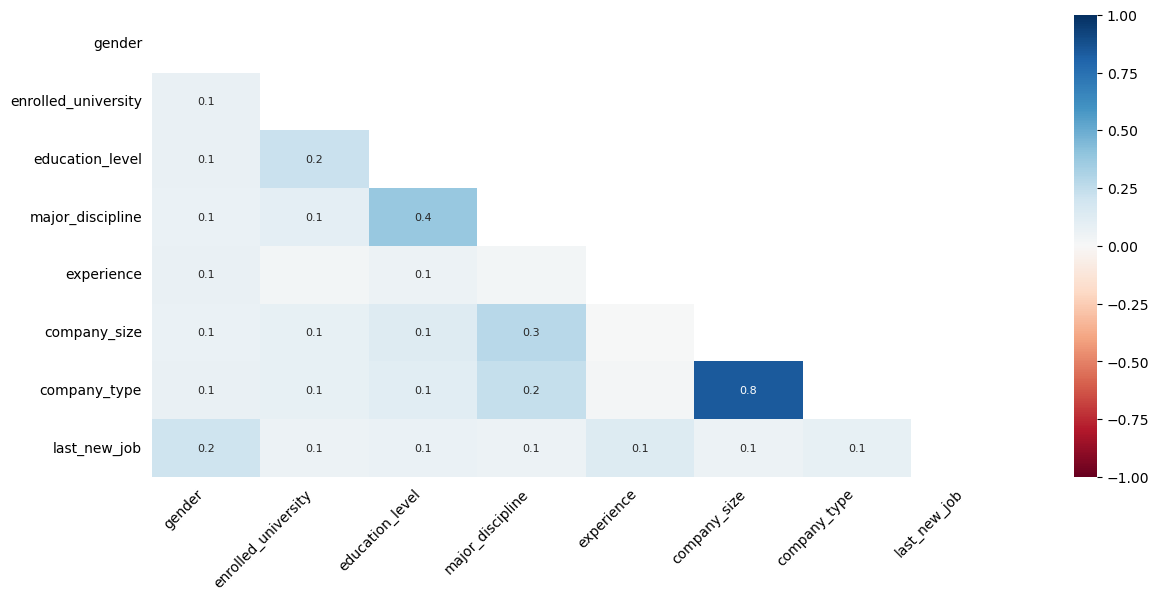

In [16]:
msno.heatmap(df_train, figsize=(14, 6), fontsize=10);

In [17]:
corr = df_train.corr().round(2)
corr["target"].sort_values()

city_development_index   -0.35
training_hours           -0.03
enrollee_id               0.04
target                    1.00
Name: target, dtype: float64

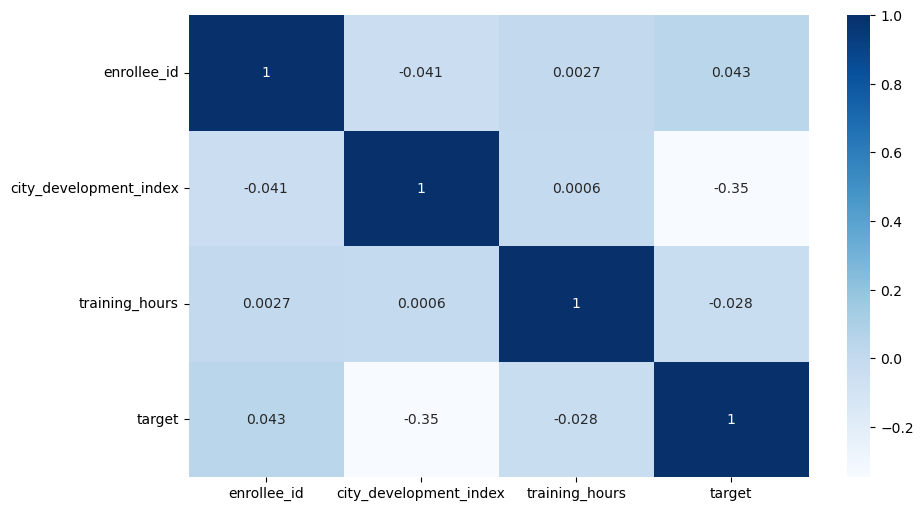

In [18]:
plot = sns.heatmap(df_train.corr(), cmap="Blues", annot=True);
# city_developement_index could be a main feature

In [19]:
# get the phi_k correlation matrix between all variables
df_train.phik_matrix()

interval columns not set, guessing: ['enrollee_id', 'city_development_index', 'training_hours', 'target']


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
enrollee_id,1.000000,0.220256,0.127163,0.087063,0.080217,0.046677,0.072162,0.029992,0.091654,0.038091,0.000000,0.040256,0.028635,0.062527
city,0.220256,1.000000,1.000000,0.156090,0.160487,0.356420,0.354353,0.160924,0.339895,0.254355,0.222911,0.235321,0.069146,0.493185
city_development_index,0.127163,1.000000,1.000000,0.064925,0.105835,0.236154,0.226298,0.125217,0.306742,0.134055,0.111368,0.174023,0.000000,0.489781
gender,0.087063,0.156090,0.064925,1.000000,0.036852,0.080936,0.068784,0.174551,0.128951,0.011189,0.107493,0.077970,0.000000,0.008314
relevent_experience,0.080217,0.160487,0.105835,0.036852,1.000000,0.238935,0.260508,0.093711,0.504904,0.064295,0.274722,0.534940,0.023084,0.201403
enrolled_university,0.046677,0.356420,0.236154,0.080936,0.238935,1.000000,0.212784,0.146168,0.437050,0.066176,0.234320,0.419145,0.000000,0.096129
education_level,0.072162,0.354353,0.226298,0.068784,0.260508,0.212784,1.000000,0.108847,0.305573,0.083473,0.113645,0.253141,0.025210,0.075835
major_discipline,0.029992,0.160924,0.125217,0.174551,0.093711,0.146168,0.108847,1.000000,0.113599,0.045983,0.083349,0.052464,0.000000,0.040029
experience,0.091654,0.339895,0.306742,0.128951,0.504904,0.437050,0.305573,0.113599,1.000000,0.125820,0.112784,0.463857,0.000000,0.243970
company_size,0.038091,0.254355,0.134055,0.011189,0.064295,0.066176,0.083473,0.045983,0.125820,1.000000,0.337461,0.096884,0.000000,0.089287


In [20]:
# get the significance matrix (expressed as one-sided Z) of the hypothesis test of each variable-pair dependency
df_train.significance_matrix()

interval columns not set, guessing: ['enrollee_id', 'city_development_index', 'training_hours', 'target']


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
enrollee_id,255.973463,11.487961,9.965193,5.586208,6.256637,2.789511,4.585132,1.296616,6.357578,1.932346,-0.066802,2.733143,0.723828,4.557110
city,11.487961,267.765559,202.263773,5.058609,9.530901,21.348012,28.063172,10.359464,24.403634,13.383539,9.575502,15.782827,1.712566,41.192985
city_development_index,9.965193,202.263773,212.311498,4.105734,8.317969,22.175107,20.807100,14.886973,38.409134,14.107378,9.994833,22.161026,-1.133862,42.067461
gender,5.586208,5.058609,4.105734,87.688082,5.773179,2.490291,6.816770,7.383062,6.259530,0.295948,3.767559,3.333530,-0.352601,1.153620
relevent_experience,6.256637,9.530901,8.317969,5.773179,130.289540,44.134159,35.434147,6.407129,46.292024,3.663040,17.169281,43.113533,1.161138,15.172505
enrolled_university,2.789511,21.348012,22.175107,2.490291,44.134159,142.768620,25.460039,9.192085,42.955369,3.981974,11.854845,30.987040,-0.030392,18.121718
education_level,4.585132,28.063172,20.807100,6.816770,35.434147,25.460039,169.478273,6.345358,32.707128,7.389282,10.841590,34.377458,0.391837,10.778758
major_discipline,1.296616,10.359464,14.886973,7.383062,6.407129,9.192085,6.345358,112.217636,7.753189,2.910464,3.581067,2.670673,0.021376,2.486621
experience,6.357578,24.403634,38.409134,6.259530,46.292024,42.955369,32.707128,7.753189,281.579520,8.112638,6.599646,61.372069,-1.051385,21.579549
company_size,1.932346,13.383539,14.107378,0.295948,3.663040,3.981974,7.389282,2.910464,8.112638,196.120279,40.162070,9.033585,0.047772,5.400370


**High Correlation between target and:**

  city (0.49)
  
  city_development_index (0.49)
  
  experience (0.24)
  
  relevent_experience (0.20)
  
  last_new_job (0.12)

### Visual EDA

#### Features

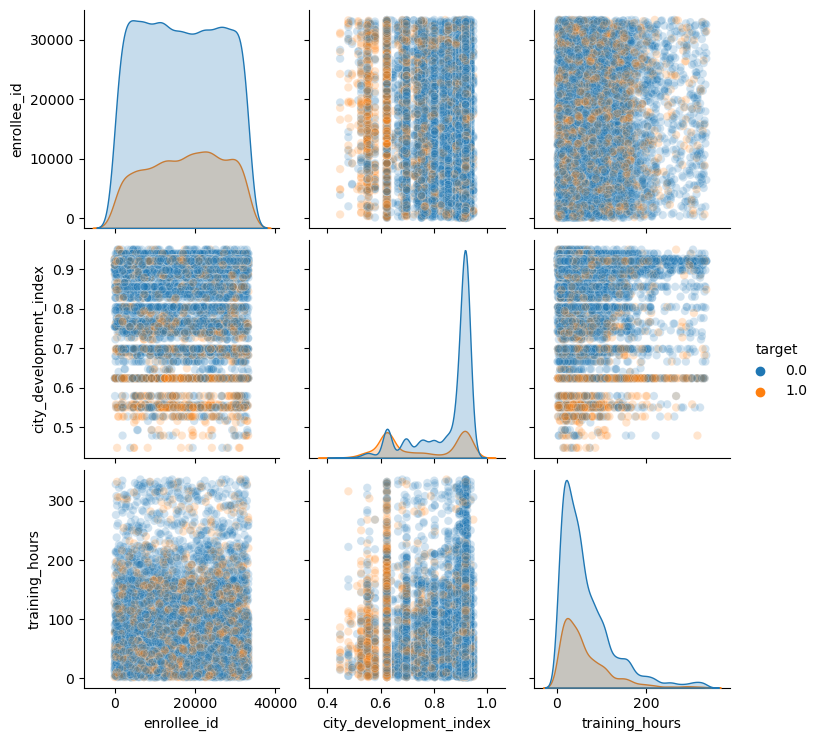

In [21]:
# Pairplot
# Target: 0 - not interested in a job change 
# Target: 1 - interested in a job change
g = sns.pairplot(df_train, hue="target", plot_kws = {'alpha': 0.2})
plt.show()

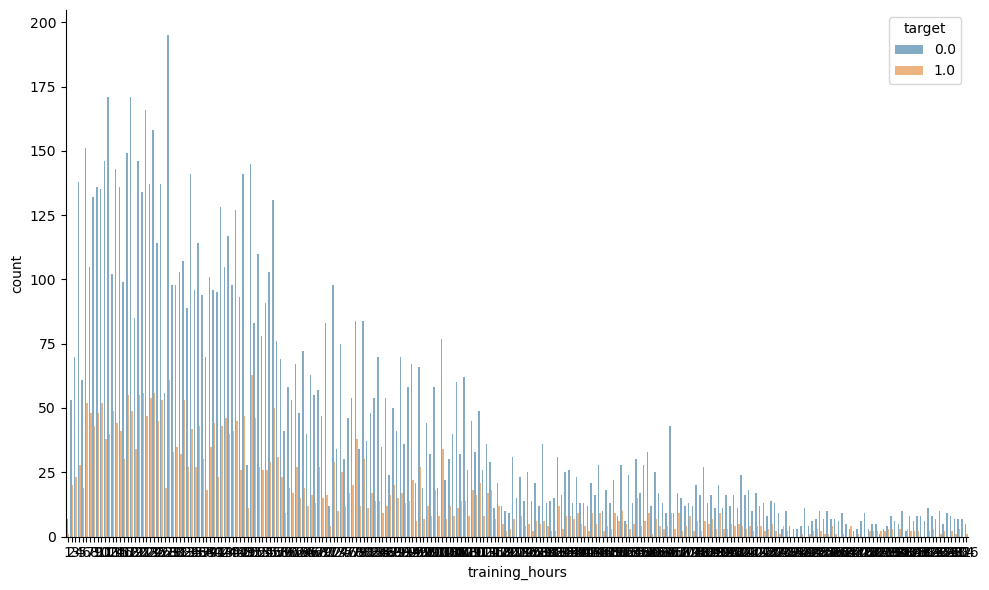

In [22]:
# Plot training_hours distribution
sns.countplot(x="training_hours", hue="target", data=df_train, alpha=0.6)
plt.tight_layout()
plt.show()

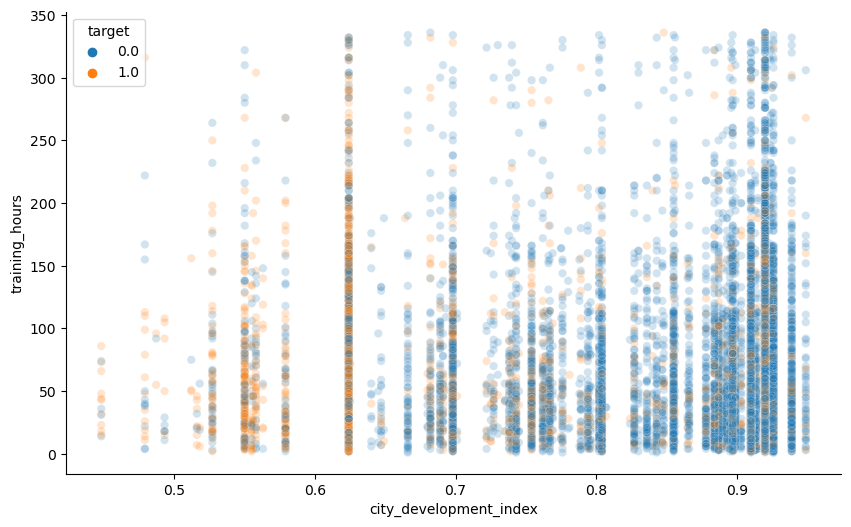

In [23]:
# Plot city development index
# Target: 0 - not interested in a job change 
# Target: 1 - interested in a job change
sns.scatterplot(data=df_train, x="city_development_index", y="training_hours", hue="target", alpha=0.2);

# Candidates from cities with a low city_development_index seem more likely to want to change jobs.

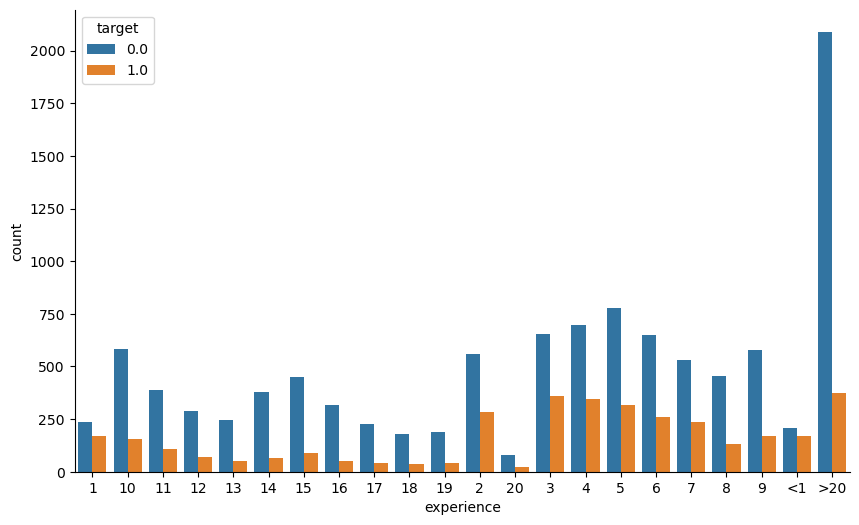

In [24]:
# Plot experimence
experience = df_train['experience'].sort_values(ascending=True)
sns.countplot(data=df_train, x=experience, hue="target");

#Candidates with 0-4 years of experience seem to be more likely to change jobs.

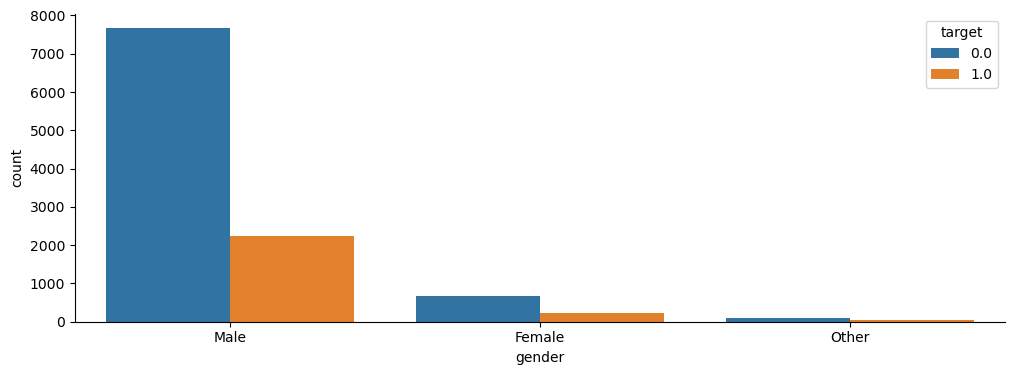

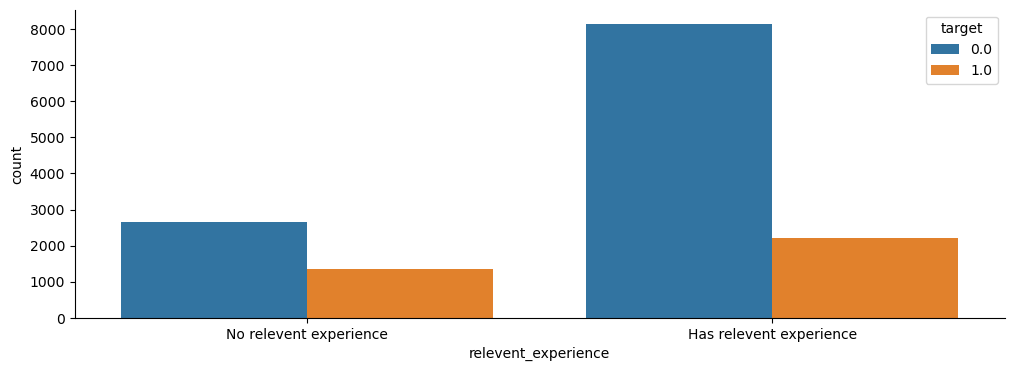

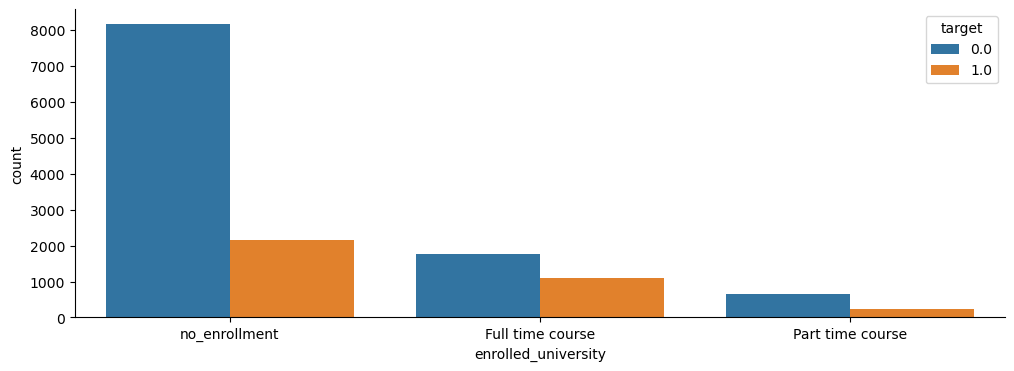

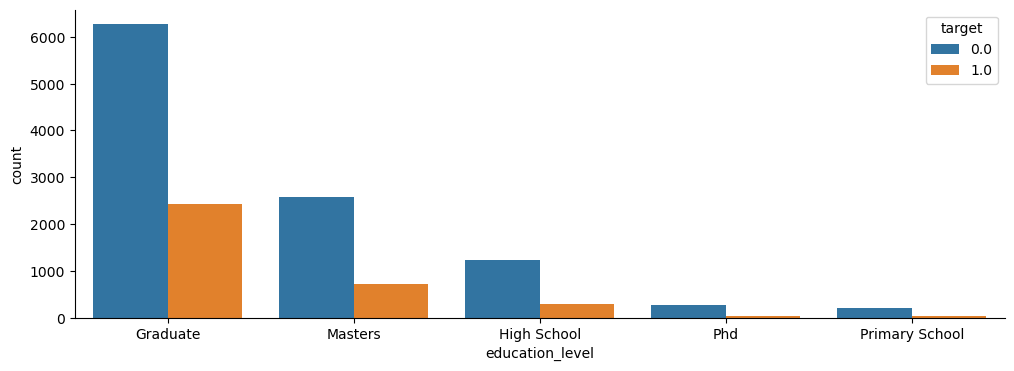

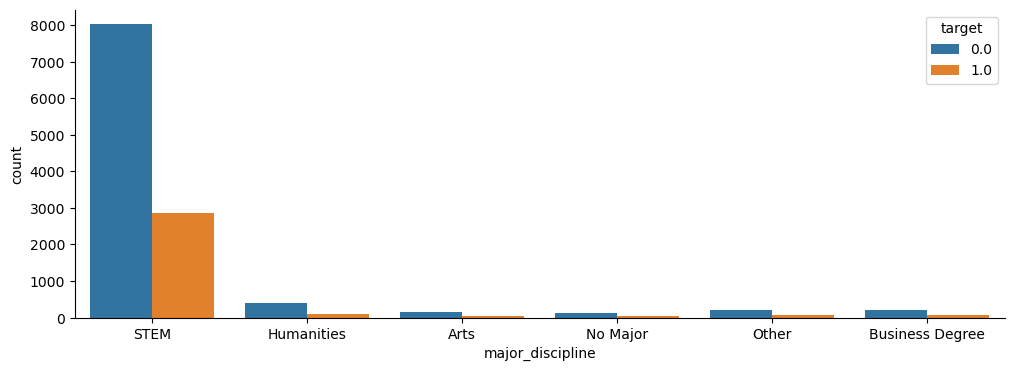

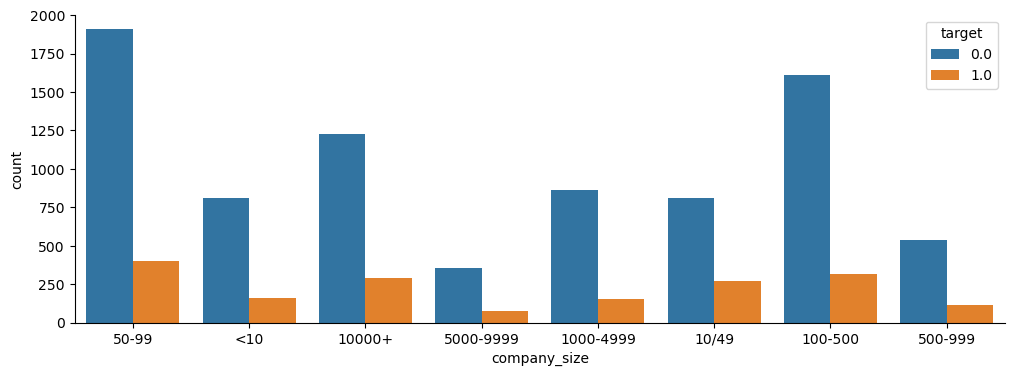

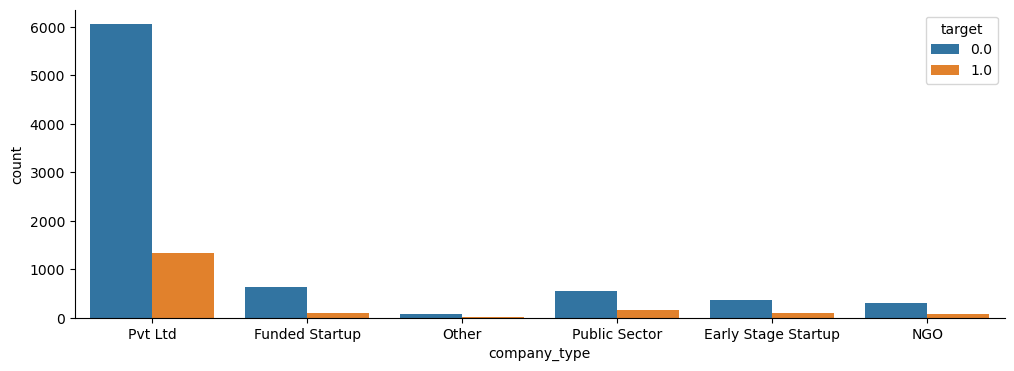

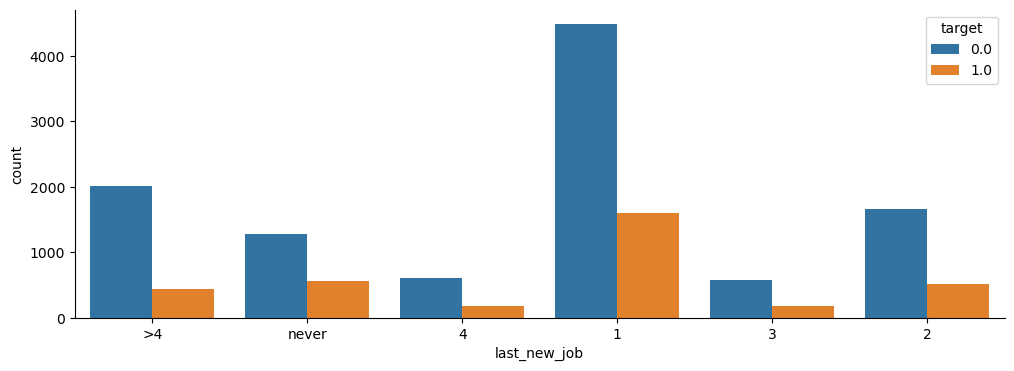

In [25]:
# Plot more categorical values
# Target: 0 - not interested in a job change 
# Target: 1 - interested in a job change

categories = ["gender","relevent_experience","enrolled_university","education_level","major_discipline","company_size","company_type","last_new_job"]
for cat in (categories):
    plt.figure(figsize=(12,4))
    sns.countplot(x=cat, hue='target', data=df_train)
    #plt.title(tit + ' vs Target')
    plt.show()

In [26]:
pd.crosstab(df_train["city"], df_train["target"]).apply(lambda r: r/r.sum(), axis=1).round(4)*100
#The city from which the candidate comes seems to have a large impact.

target,0.0,1.0
city,,
city_1,95.00,5.00
city_10,88.89,11.11
city_100,75.60,24.40
city_101,40.74,59.26
city_102,83.91,16.09
...,...,...
city_93,79.17,20.83
city_94,52.38,47.62
city_97,90.24,9.76


In [27]:
pd.crosstab(df_train["major_discipline"], df_train["target"]).apply(lambda r: r/r.sum(), axis=1).round(4)*100
#The major_discipline seems to have a relatively low impact.

target,0.0,1.0
major_discipline,,
Arts,81.08,18.92
Business Degree,76.56,23.44
Humanities,79.14,20.86
No Major,79.17,20.83
Other,74.09,25.91
STEM,73.69,26.31


In [28]:
pd.crosstab(df_train["company_size"], df_train["target"]).apply(lambda r: r/r.sum(), axis=1).round(4)*100

target,0.0,1.0
company_size,,
10/49,74.81,25.19
100-500,83.65,16.35
1000-4999,85.04,14.96
10000+,81.01,18.99
50-99,82.63,17.37
500-999,82.80,17.20
5000-9999,82.09,17.91
<10,83.59,16.41


In [29]:
pd.crosstab(df_train["company_type"], df_train["target"]).apply(lambda r: r/r.sum(), axis=1).round(4)*100
# Company size and company type seem to have a significant impact.

target,0.0,1.0
company_type,,
Early Stage Startup,77.78,22.22
Funded Startup,87.12,12.88
NGO,81.15,18.85
Other,74.19,25.81
Public Sector,77.98,22.02
Pvt Ltd,81.91,18.09


In [30]:
pd.crosstab(df_train["last_new_job"], df_train["target"]).apply(lambda r: r/r.sum(), axis=1).round(4)*100
# Especially young professionals without work experience seem to be open to job opportunities. 

target,0.0,1.0
last_new_job,,
1,73.73,26.27
2,76.56,23.44
3,76.89,23.11
4,77.78,22.22
>4,81.86,18.14
never,69.47,30.53


#### Target (imbalanced)

In [31]:
df_train.target.value_counts(normalize=True)

0.0    0.751462
1.0    0.248538
Name: target, dtype: float64

> About 75% do not want to change their job while 25% are open to a job change.

> Target value is imbalanced what can bias the output of our analyses. (Classifier tend to predict the majority class.)

**Solution:**

Synthesize elements for the minority class, in the vicinity of already existing elements. (Oversampling)

At a high level, SMOTE creates synthetic observations of the minority class (target 1) by:

 - Finding the k-nearest-neighbors for minority class observations (finding similar observations)
 - Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observation.
 
**Requirments: numerical values without missing values**

smote= SMOTE()

X, y = smote.fit_resample(X, y)

## Research questions

**Predict the probability of a candidate looking for a new job.**

**Which variables have the greatest impact?**

## Feature Engineering

In [32]:
df_train.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

In [33]:
train_set = df_train.drop("target", axis=1) # drop labels for training set
train_labels = df_train["target"].copy()

In [34]:
train_set.shape

(14368, 13)

In [35]:
train_labels.shape

(14368,)

In [36]:
test_set = df_test.drop("target", axis=1) # drop labels for training set
test_labels = df_test["target"].copy()

In [37]:
test_set.shape

(4790, 13)

In [38]:
test_labels.shape

(4790,)

In [39]:
# categorical values:
cat_train = train_set[['city', 'gender', 'relevent_experience', 'enrolled_university', 
                       'education_level', 'major_discipline', 'experience', 'company_size',
                       'company_type', 'last_new_job']]
#numeric values:
num_train = train_set[['city_development_index', 'training_hours']]

### Handling missing values

#### Numerical values

In [40]:
num_train_imp = num_train.fillna(num_train.mean())

In [41]:
num_train_imp.isna().sum().sort_values(ascending=False)

city_development_index    0
training_hours            0
dtype: int64

#### Categorical values

In [42]:
#analysis of feature value counts:
for col in cat_train.columns:
    print(cat_train[col].value_counts())

city_103    3206
city_21     1991
city_16     1153
city_114    1035
city_160     633
            ... 
city_139       3
city_31        3
city_121       2
city_111       2
city_171       1
Name: city, Length: 122, dtype: int64
Male      9907
Female     915
Other      136
Name: gender, dtype: int64
Has relevent experience    10356
No relevent experience      4012
Name: relevent_experience, dtype: int64
no_enrollment       10329
Full time course     2856
Part time course      893
Name: enrolled_university, dtype: int64
Graduate          8689
Masters           3289
High School       1501
Phd                306
Primary School     241
Name: education_level, dtype: int64
STEM               10891
Humanities           489
Other                274
Business Degree      256
Arts                 185
No Major             168
Name: major_discipline, dtype: int64
>20    2466
5      1096
4      1043
3      1016
6       910
2       839
7       768
9       748
10      740
8       587
15      539
11      4

In [43]:
cat_train.head()

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
1,city_40,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4
2,city_21,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never
4,city_162,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4
5,city_176,NaN,Has relevent experience,Part time course,Graduate,STEM,11,NaN,NaN,1
7,city_46,Male,Has relevent experience,no_enrollment,Graduate,STEM,13,<10,Pvt Ltd,>4


In [44]:
cat_train.isna().sum().sort_values(ascending=False)

company_type           4628
company_size           4475
gender                 3410
major_discipline       2105
education_level         342
last_new_job            312
enrolled_university     290
experience               46
city                      0
relevent_experience       0
dtype: int64

In [45]:
# fill every column with its own most frequent value
cat_train_imp = cat_train.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [46]:
# all Nan values replaced
cat_train_imp.isna().sum().sort_values(ascending=False)

city                   0
gender                 0
relevent_experience    0
enrolled_university    0
education_level        0
major_discipline       0
experience             0
company_size           0
company_type           0
last_new_job           0
dtype: int64

In [47]:
cat_train_imp.head()

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
1,city_40,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4
2,city_21,Male,No relevent experience,Full time course,Graduate,STEM,5,50-99,Pvt Ltd,never
4,city_162,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4
5,city_176,Male,Has relevent experience,Part time course,Graduate,STEM,11,50-99,Pvt Ltd,1
7,city_46,Male,Has relevent experience,no_enrollment,Graduate,STEM,13,<10,Pvt Ltd,>4


In [48]:
# Save cleaned df (numerical and categorical columns, no missings)
df_train_clean = pd.concat([cat_train_imp, num_train_imp, train_labels], axis=1)
df_train_clean.head()

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,city_development_index,training_hours,target
1,city_40,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,0.776,47,0.0
2,city_21,Male,No relevent experience,Full time course,Graduate,STEM,5,50-99,Pvt Ltd,never,0.624,83,0.0
4,city_162,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,0.767,8,0.0
5,city_176,Male,Has relevent experience,Part time course,Graduate,STEM,11,50-99,Pvt Ltd,1,0.764,24,1.0
7,city_46,Male,Has relevent experience,no_enrollment,Graduate,STEM,13,<10,Pvt Ltd,>4,0.762,18,1.0


### Encoding categorical data

#### OneHotEncoder (all categorical data)

In [49]:
# Encoding (first variation) OneHotEncoder for all categorical data

encoder = OneHotEncoder(categories='auto')
cat_train_encoded = encoder.fit_transform(cat_train_imp)
cat_train_encoded

<14368x183 sparse matrix of type '<class 'numpy.float64'>'
	with 143680 stored elements in Compressed Sparse Row format>

#### Dummy Variable Encoder (all categorical data)

In [50]:
# Encoding (second variation) Get dummy variables 

cat_train_dummies = pd.get_dummies(cat_train, drop_first=False)
cat_train_dummies.head(3)

,city_city_1,city_city_10,city_city_100,city_city_101,city_city_102,city_city_103,city_city_104,city_city_105,city_city_106,city_city_107,...,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_1,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [51]:
cat_train_dummies.shape

(14368, 183)

#### OneHotEncoder (selected columns)

Instead of handling all categorial variables with OneHotEncoding, a separation would also be conceivable:

**Encoder 1:**
OneHotEncoder for equivalent expressions that do not have a specific order or significance:
'city', 'gender', 'enrolled_university', 'relevent_experience'

**Encoder 2:**
OrdinalEncoder for equivalent expressions that have a specific order:
'last_new_job', 'experience', 'company_size'


In [52]:
Encoder1 = OneHotEncoder()
cat_train1 = cat_train[['city', 'gender', 'relevent_experience', 'enrolled_university']]
cat_train_enc1 = Encoder1.fit_transform(cat_train1)
cat_train_enc1

<14368x132 sparse matrix of type '<class 'numpy.float64'>'
	with 57472 stored elements in Compressed Sparse Row format>

#### OrdinalEncoder (selected columns)

In [53]:
cat_train2 = cat_train_imp[[ "education_level", "company_size", "last_new_job", "experience"]]

mapping = [{
    "col":"education_level", "mapping": {
        'Primary School':1, 
        'High School':2, 
        'Graduate':3, 
        'Masters':4, 
        'Phd':5, 
    }},
    {
    "col":"company_size", "mapping": {
        '<10':1, 
        '10/49':2, 
        '50-99':3, 
        '100-500':4, 
        '500-999':5, 
        '1000-4999':6,
        '5000-9999':7,
        '10000+':8,
        'not_specified':9
    }},
    {
    "col":"last_new_job", "mapping": {
        'never':1, 
        '1':2, 
        '2':3, 
        '3':4, 
        '4':5, 
        '>4':6
    }},
    {
    "col":"experience", "mapping": {
        '<1':1, 
        '1':2, 
        '2':3, 
        '3':4, 
        '4':5, 
        '5':6,
        '6':7, 
        '7':8, 
        '8':9, 
        '9':10, 
        '10':11,
        '11':12, 
        '12':13, 
        '13':14, 
        '14':15, 
        '15':16,
        '16':17, 
        '17':18, 
        '18':19, 
        '19':20, 
        '20':21, 
        '>20':22
          }}
]


Encoder2 = ce.OrdinalEncoder(mapping=mapping, cols=None,
                         return_df = True)  
cat_train_enc2 = Encoder2.fit_transform(cat_train2)
cat_train_enc2

,education_level,company_size,last_new_job,experience
1,3,3,6,16
2,3,3,1,6
4,4,3,5,22
5,3,3,2,12
7,3,1,6,14
...,...,...,...,...
19151,3,3,2,3
19152,3,2,2,8
19153,3,3,2,15
19155,3,3,5,22


## Preprocessing Pipeline

In [54]:
# Import data 
data1 = pd.read_csv(HR_ANALYSIS_PATH)
data1.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [55]:
#Replacing the Nan values of the categorical values with mode of that column
#Label Encoding
data1['company_type'] = data1['company_type'].fillna(data1['company_type'].value_counts().index[0])
CTypeLabelEncoder = LabelEncoder().fit(data1['company_type'])
CTypeList = CTypeLabelEncoder.classes_
data1['company_type'] = CTypeLabelEncoder.transform(data1['company_type'])

data1['company_size'].replace(['<10','10/49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+',],
                             ['Startup','Small','Small','Medium','Medium','Large','Large','Large'],inplace=True)
data1['company_size'] = data1['company_size'].fillna(data1['company_size'].value_counts().index[0])
CSizeLabelEncoder = LabelEncoder().fit(data1['company_size'])
CSizeList = CSizeLabelEncoder.classes_
data1['company_size'] = CSizeLabelEncoder.transform(data1['company_size'])

data1['education_level'] = data1['education_level'].fillna(data1['education_level'].value_counts().index[0])
EduLabelEncoder = LabelEncoder().fit(data1['education_level'])
EduList = EduLabelEncoder.classes_
data1['education_level'] = EduLabelEncoder.transform(data1['education_level'])

data1['enrolled_university'] = data1['enrolled_university'].fillna(data1['enrolled_university'].value_counts().index[0])
UniLabelEncoder = LabelEncoder().fit(data1['enrolled_university'])
UniList = UniLabelEncoder.classes_
data1['enrolled_university'] = UniLabelEncoder.transform(data1['enrolled_university'])

data1['target'] = data1['target'].fillna(data1['target'].value_counts().index[0])

data1['relevent_experience'] = data1['relevent_experience'].fillna(data1['relevent_experience'].value_counts().index[0])
ExpLabelEncoder = LabelEncoder().fit(data1['relevent_experience'])
ExpList = ExpLabelEncoder.classes_
data1['relevent_experience'] = ExpLabelEncoder.transform(data1['relevent_experience'])

# extreme values in the 'last_new_job' and 'experience' 
data1['last_new_job'].replace(['>4','never'],['5','0'],inplace=True)
data1['last_new_job'].fillna(data1['last_new_job'].value_counts().index[0],inplace=True)
data1['last_new_job'] = [float(i) for i in data1['last_new_job']]

data1['experience'].replace(['>20','<1'],['21','0'],inplace=True)
data1['experience'].fillna(data1['experience'].value_counts().index[0],inplace=True)
data1['experience'] = [float(i) for i in data1['experience']]

# Missing values in the numerical columns are replaced with the its mean
data1['training_hours'] = data1['training_hours'].fillna(data1['training_hours'].mean())
data1['training_hours'] = [float(i) for i in data1['training_hours']]
data1['city_development_index'] = data1['city_development_index'].fillna(data1['city_development_index'].mean())

In [56]:
data2 = data1.drop(data1.loc[:, ['enrollee_id', 'city','major_discipline', 'gender']].columns, axis=1)
data2.shape

(19158, 10)

In [57]:
#Oversampling the minority labels - to reduce imbalance in the label count of each column in data
X_org = data2[data2.columns[:len(data2.columns)-1]].to_numpy()
Y_org = data2[data2.columns[len(data2.columns)-1]].to_numpy()
over = SMOTE(random_state=42)
X, Y = over.fit_resample(X_org,Y_org)

In [58]:
#Splitting the data into training set and test set
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,shuffle=True,random_state=42)

In [59]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(23009, 9)
(5753, 9)
(23009,)
(5753,)


## GridSearch / Confusion Matrix

{'n_neighbors': 3, 'p': 1}
Accuracy score : 0.78
Recall score : 0.79
Precision score : 0.86
F1 score : 0.79


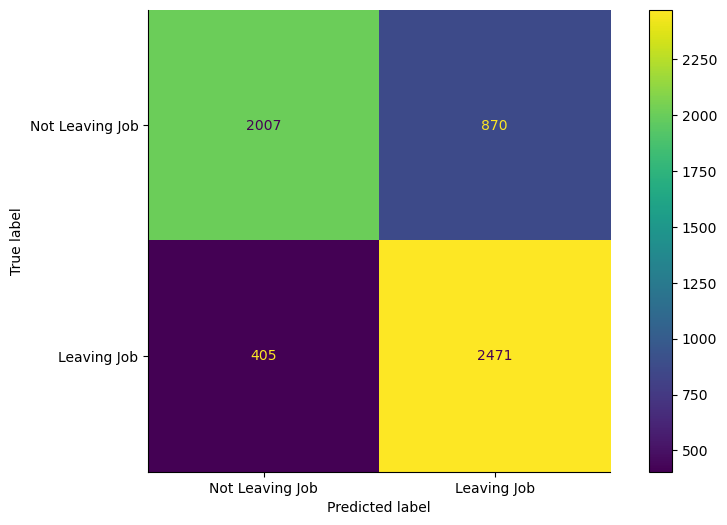

In [60]:
from sklearn.metrics import recall_score,precision_score,accuracy_score, f1_score, ConfusionMatrixDisplay,roc_auc_score,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
GridSearch = True
if GridSearch == True:
    param_grid = {'n_neighbors': np.arange(3,50), 'p':[1,2]}
    knn = KNeighborsClassifier()
    knn_cv = GridSearchCV(knn, param_grid, cv=10)
    knn_cv.fit(X_train, Y_train)
    print(knn_cv.best_params_)
    knnpre = knn_cv.predict(X_test)
    knncm = confusion_matrix(Y_test,knnpre)
    print("Accuracy score : {:.2f}".format(accuracy_score(knnpre,Y_test)))
    print("Recall score : {:.2f}".format(recall_score(knnpre,Y_test,average='macro',zero_division=True)))
    print("Precision score : {:.2f}".format(precision_score(knnpre,Y_test,zero_division = True)))
    print("F1 score : {:.2f}".format(f1_score(knnpre,Y_test,zero_division=True)))
    dis = ConfusionMatrixDisplay(knncm,display_labels=["Not Leaving Job","Leaving Job"])
    dis.plot()
    plt.show()

## Calculating Feature Importance

In [61]:
# fitting the model
model = DecisionTreeClassifier(max_depth=6)
model.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=6)

In [62]:
# plotting feature importances
features = data2.drop('target', axis=1).columns
importances = model.feature_importances_
indices = np.argsort(importances)

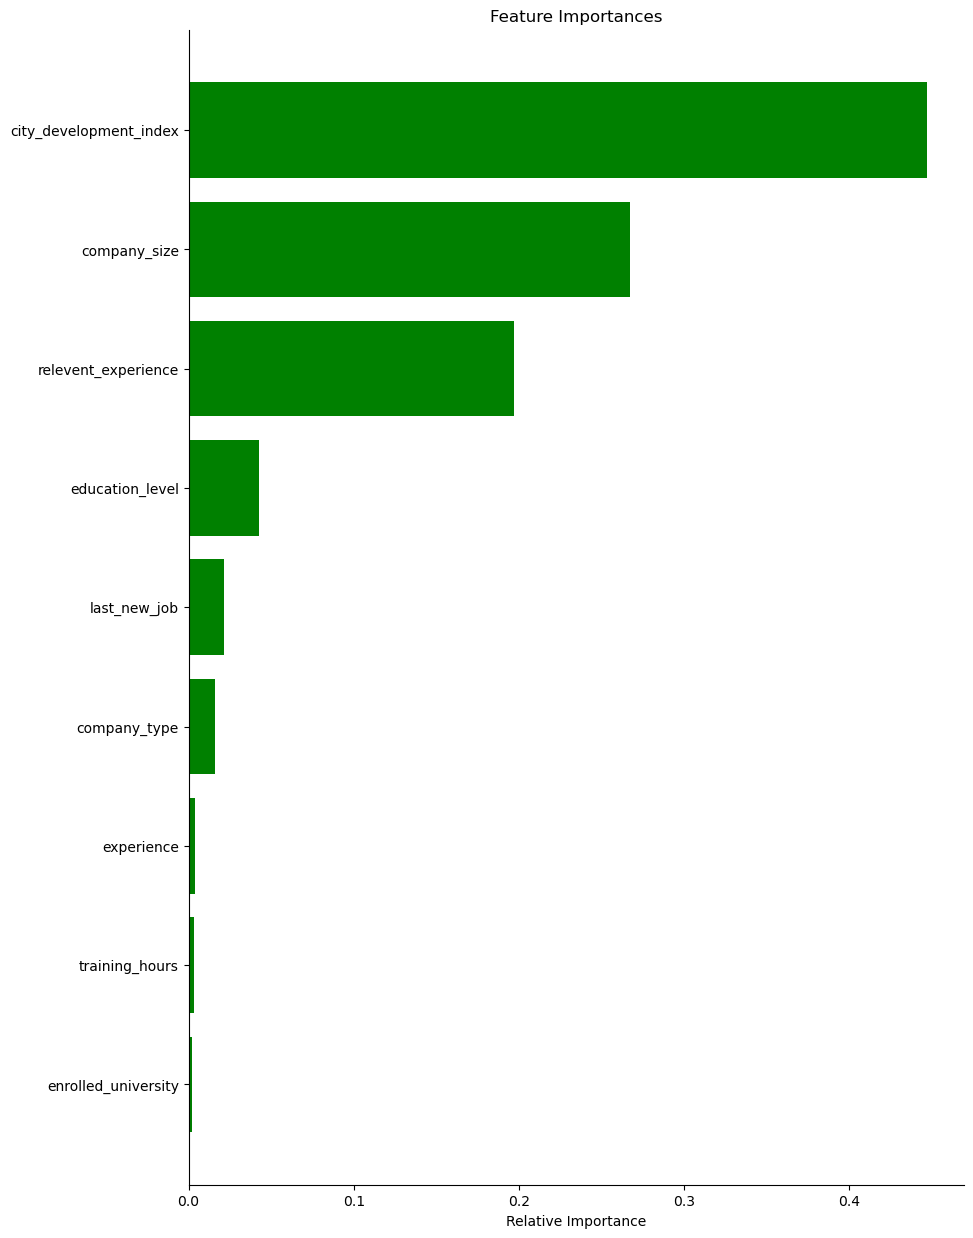

In [63]:
plt.figure(figsize=(10,15))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Logit Regression

In [64]:
data2.head(3)

,city_development_index,relevent_experience,enrolled_university,education_level,experience,company_size,company_type,last_new_job,training_hours,target
0,0.920,0,2,0,21.0,2,5,1.0,36.0,1.0
1,0.776,1,2,0,15.0,2,5,5.0,47.0,0.0
2,0.624,1,0,0,5.0,2,5,0.0,83.0,0.0


In [65]:
data2.columns

Index(['city_development_index', 'relevent_experience', 'enrolled_university',
       'education_level', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

In [66]:
data2['target'].astype(np.int64)

0        1
1        0
2        0
3        1
4        0
        ..
19153    1
19154    1
19155    0
19156    0
19157    0
Name: target, Length: 19158, dtype: int64

### Model 1

In [67]:
model1 = smf.logit("target ~ city_development_index + experience", data=data2)

In [68]:
results1 = model1.fit()

Optimization terminated successfully.
         Current function value: 0.504232
         Iterations 6


In [69]:
print(results1.summary())

                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                19158
Model:                          Logit   Df Residuals:                    19155
Method:                           MLE   Df Model:                            2
Date:                Wed, 09 Nov 2022   Pseudo R-squ.:                  0.1022
Time:                        11:45:51   Log-Likelihood:                -9660.1
converged:                       True   LL-Null:                       -10759.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3.6235      0.108     33.565      0.000       3.412       3.835
city_development_index    -5.5037      0.141    -39.010      0.000      -5.780      -5.227
expe

### Model 2

In [70]:
model2 = smf.logit("target ~ last_new_job + city_development_index + relevent_experience + experience", data=data2)

In [71]:
results2 = model2.fit()

Optimization terminated successfully.
         Current function value: 0.499620
         Iterations 6


In [72]:
print(results2.summary())

                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                19158
Model:                          Logit   Df Residuals:                    19153
Method:                           MLE   Df Model:                            4
Date:                Wed, 09 Nov 2022   Pseudo R-squ.:                  0.1104
Time:                        11:45:51   Log-Likelihood:                -9571.7
converged:                       True   LL-Null:                       -10759.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3.4653      0.109     31.781      0.000       3.252       3.679
last_new_job               0.0412      0.013      3.230      0.001       0.016       0.066
city

### Model 3

In [73]:
model3 = smf.logit("target ~ city_development_index + experience + last_new_job + relevent_experience + enrolled_university+ education_level + company_size  + company_type + training_hours", data=data2)

In [74]:
results3 = model3.fit()

Optimization terminated successfully.
         Current function value: 0.492163
         Iterations 6


In [75]:
print(results3.summary())

                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                19158
Model:                          Logit   Df Residuals:                    19148
Method:                           MLE   Df Model:                            9
Date:                Wed, 09 Nov 2022   Pseudo R-squ.:                  0.1237
Time:                        11:45:51   Log-Likelihood:                -9428.9
converged:                       True   LL-Null:                       -10759.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  2.8617      0.141     20.312      0.000       2.586       3.138
city_development_index    -5.6049      0.145    -38.617      0.000      -5.889      -5.320
expe

### Model 4, best Pseudo R-Squ.= 0.151

In [76]:
model4 = smf.logit("target ~ city_development_index + experience + last_new_job + relevent_experience + enrolled_university+ education_level + company_size  + company_type + training_hours", data=df_train_clean)

In [77]:
results4 = model4.fit()

Optimization terminated successfully.
         Current function value: 0.476050
         Iterations 6


In [78]:
print(results4.summary())

                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                14368
Model:                          Logit   Df Residuals:                    14320
Method:                           MLE   Df Model:                           47
Date:                Wed, 09 Nov 2022   Pseudo R-squ.:                  0.1510
Time:                        11:45:52   Log-Likelihood:                -6839.9
converged:                       True   LL-Null:                       -8056.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                         4.0687      0.221     18.440      0.000       3.636       4.501
experience[T.10]          

### Model 5

In [79]:
model5 = smf.logit("target ~ city_development_index  + last_new_job + experience*relevent_experience + enrolled_university*education_level + training_hours", data=data2)

In [80]:
results5 = model5.fit()

Optimization terminated successfully.
         Current function value: 0.495668
         Iterations 6


In [81]:
print(results5.summary())

                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                19158
Model:                          Logit   Df Residuals:                    19148
Method:                           MLE   Df Model:                            9
Date:                Wed, 09 Nov 2022   Pseudo R-squ.:                  0.1174
Time:                        11:45:52   Log-Likelihood:                -9496.0
converged:                       True   LL-Null:                       -10759.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               3.7971      0.119     31.776      0.000       3.563       4.031
city_development_index                 -5.6375      0.14

**Findings:**

- city_development_index, experience, last_new_job, relevent_experience, enrolled_university, education_level and training_hours have a significant influence

- company_size  has a significant influence while company_type seams to have an negligible influence

- last new job is highly significant especially for young professionals


## Decision Tree 

In [82]:
df_train_clean.head(3)

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,city_development_index,training_hours,target
1,city_40,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,0.776,47,0.0
2,city_21,Male,No relevent experience,Full time course,Graduate,STEM,5,50-99,Pvt Ltd,never,0.624,83,0.0
4,city_162,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,0.767,8,0.0


In [83]:
feature_selection = ['relevent_experience', 'enrolled_university', 'relevent_experience',
       'education_level', 'experience', 'last_new_job', 'city_development_index',
       'training_hours']
df = df_train_clean

In [84]:
def split_x_y(df, features):
    y = df["target"]
    X = df.loc[: , features]
    X = pd.get_dummies(X)
    return X, y

In [85]:
X_train, y_train = split_x_y(df_train, feature_selection)

In [86]:
print("Shape y:", y_train.shape)
y_train.head()

Shape y: (14368,)


1    0.0
2    0.0
4    0.0
5    1.0
7    1.0
Name: target, dtype: float64

In [87]:
print("Shape X:", X_train.shape)
X_train.head()

Shape X: (14368, 42)


,city_development_index,training_hours,relevent_experience_Has relevent experience,relevent_experience_No relevent experience,enrolled_university_Full time course,enrolled_university_Part time course,enrolled_university_no_enrollment,relevent_experience_Has relevent experience,relevent_experience_No relevent experience,education_level_Graduate,...,experience_8,experience_9,experience_<1,experience_>20,last_new_job_1,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never
1,0.776,47,0,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,1,0
2,0.624,83,0,1,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
4,0.767,8,1,0,0,0,1,1,0,0,...,0,0,0,1,0,0,0,1,0,0
5,0.764,24,1,0,0,1,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
7,0.762,18,1,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0


### DecisionTreeClassifier(max_depth=3)

In [88]:
model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

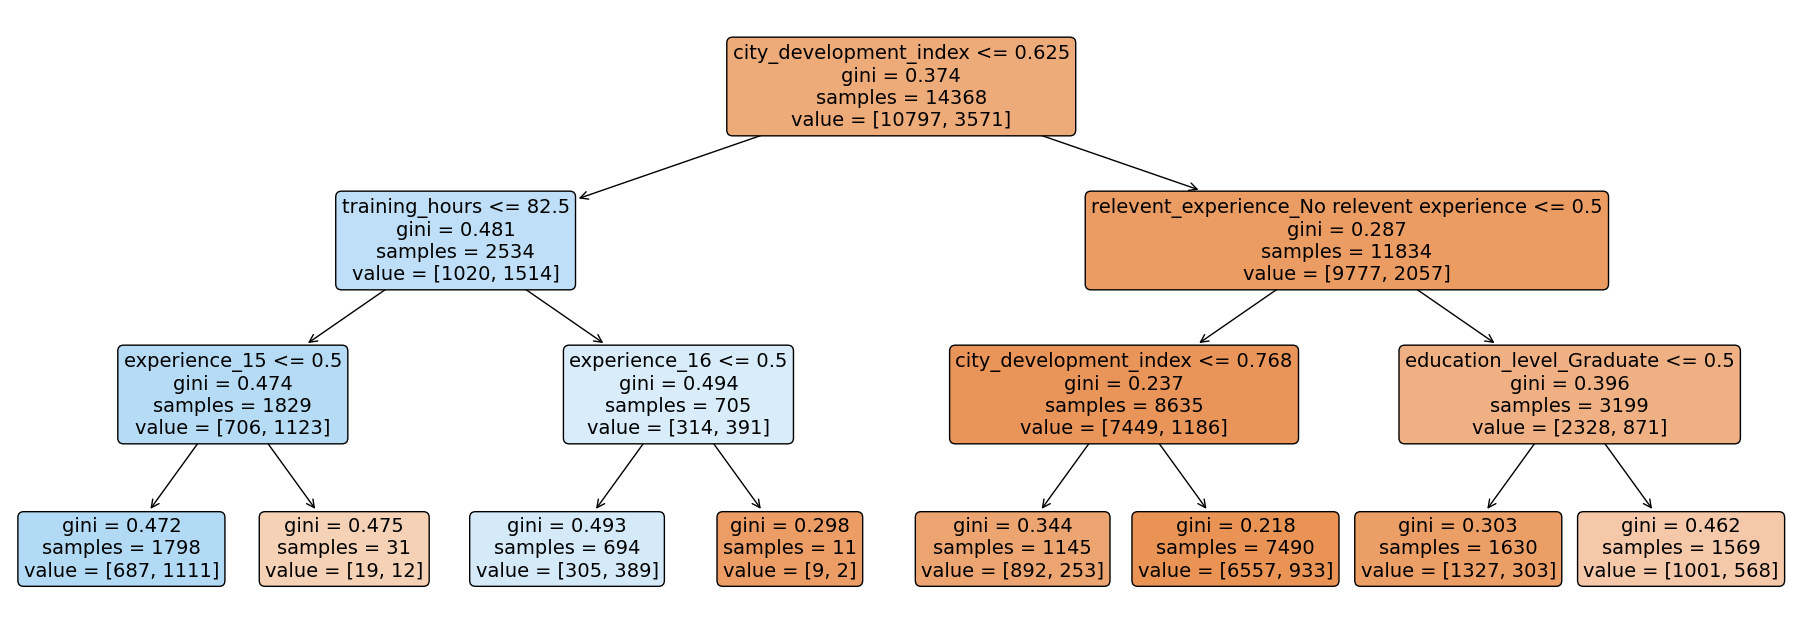

In [89]:
fig = plt.figure(figsize=(23,8))
_ = tree.plot_tree(model, 
                   feature_names=X_train.columns,                   
                   filled=True, rounded=True, fontsize=14)

### DecisionTreeClassifier(max_depth=4)

In [90]:
model = DecisionTreeClassifier(max_depth=4)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

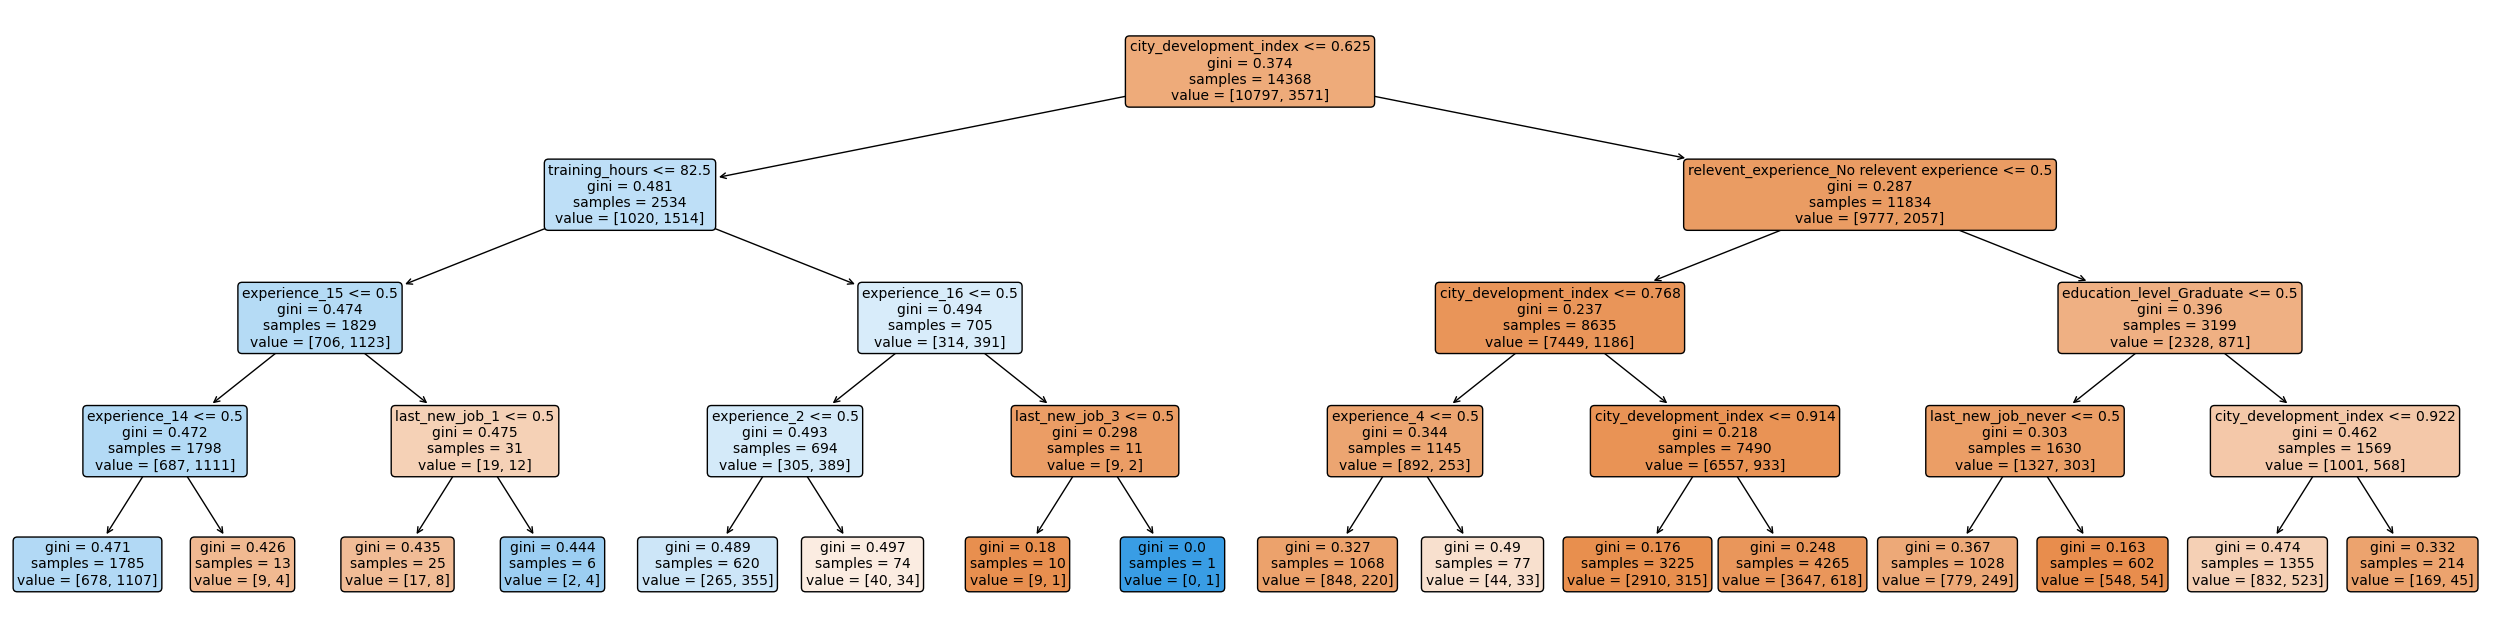

In [91]:
fig = plt.figure(figsize=(32,8))
_ = tree.plot_tree(model, 
                   feature_names=X_train.columns,                   
                   filled=True, rounded=True, fontsize=10)

**Findings:**
- The biggest influencing factor is city_development_index, where the limit is 0.625. Below this, candidates are more willing to change jobs.
- On the second and third level, for candidates with city_development_index below 0.625, the completed training hours and the professional experience in years play an important role in the decision.
- For candidates with a city_development_index of more than 0.625, on the other hand, the existence of relevant experience at the second level is decisive. On the third level, we find a further improvement in the city_development_index and graduates, i.e. young professionals.


**References:**  
https://www.kaggle.com/code/gokberkyucelkaya/hr-analytics-job-change-of-data-scientists   
https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a  
https://www.kaggle.com/code/thirunaavukkarasu/random-forest-84-accuracy  
